In [161]:
'''
If you are using Google Colab, uncomment the next lines to download fast text and datasets
'''

!pip install fasttext
!wget https://raw.githubusercontent.com/L3peha/internshipVK/main/raw/test_spam.csv
!wget https://raw.githubusercontent.com/L3peha/internshipVK/main/raw/train_spam.csv

--2024-05-02 18:14:50--  https://raw.githubusercontent.com/L3peha/internshipVK/main/raw/test_spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1341081 (1.3M) [text/plain]
Saving to: ‘test_spam.csv.1’

test_spam.csv.1     100%[===================>]   1.28M  --.-KB/s    in 0.07s   

2024-05-02 18:14:50 (17.5 MB/s) - ‘test_spam.csv.1’ saved [1341081/1341081]

--2024-05-02 18:14:50--  https://raw.githubusercontent.com/L3peha/internshipVK/main/raw/train_spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5399880 (5.1M) [tex

In [162]:
import fasttext

In [163]:
#help(fasttext.FastText)

In [164]:
'''
import pandas as pd

df = pd.read_csv("train_spam.csv")
#print(type(df))
df.loc[df["text_type"]=="ham", "text_type"] = "__label__ham"
df.loc[df["text_type"]=="spam", "text_type"] = "__label__spam"
#con = str(df(header=False, index=False))
#print(con, file = open('temp.txt', 'w'))
df.to_csv("temp.csv", index=False, header=False)
'''

'\nimport pandas as pd\n\ndf = pd.read_csv("train_spam.csv")\n#print(type(df))\ndf.loc[df["text_type"]=="ham", "text_type"] = "__label__ham"\ndf.loc[df["text_type"]=="spam", "text_type"] = "__label__spam"\n#con = str(df(header=False, index=False))\n#print(con, file = open(\'temp.txt\', \'w\'))\ndf.to_csv("temp.csv", index=False, header=False)\n'

In [165]:
'''
import csv
with open('train.txt', "w") as f_out:
    with open('temp.csv', "r") as f_in:
        [ f_out.write(" ".join(row)+'\n') for row in csv.reader(f_in)]
    f_out.close()
'''

'\nimport csv\nwith open(\'train.txt\', "w") as f_out:\n    with open(\'temp.csv\', "r") as f_in:\n        [ f_out.write(" ".join(row)+\'\n\') for row in csv.reader(f_in)]\n    f_out.close()\n'

In [166]:
'''
with open('train_spam.csv', 'r') as f_in, open('tempp.txt', 'w') as f_out:
  cont = f_in.read().replace('ham,','__label__ham ')
  cont = f_in.read().replace('spam,','__label__spam ')
  f_out.write(cont)
'''

"\nwith open('train_spam.csv', 'r') as f_in, open('tempp.txt', 'w') as f_out:\n  cont = f_in.read().replace('ham,','__label__ham ')\n  cont = f_in.read().replace('spam,','__label__spam ')\n  f_out.write(cont)\n"

In [167]:
#!cat train.txt | sed -e "s/\([.\!?,'/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > train.txt

In [168]:
#!wc train.txt

In [169]:
'''
!head -n 13280 train.txt > spam.train
!tail -n 3000 train.txt > spam.valid
'''

'\n!head -n 13280 train.txt > spam.train\n!tail -n 3000 train.txt > spam.valid\n'

In [170]:
'''
model = fasttext.train_supervised(input = "spam.train")
model.save_model("spam.bin")
model.test("spam.valid")
'''

'\nmodel = fasttext.train_supervised(input = "spam.train")\nmodel.save_model("spam.bin")\nmodel.test("spam.valid")\n'

In [171]:
'''
model1 = fasttext.train_supervised(input = "spam.train", lr=1.0, epoch=25)
print(model1.test("spam.valid"))
'''

'\nmodel1 = fasttext.train_supervised(input = "spam.train", lr=1.0, epoch=25)\nprint(model1.test("spam.valid"))\n'

In [172]:
#model.save_model("spam.bin")

In [173]:
#print(model.labels)

In [174]:
! pip install scikit-plot

In [175]:
#mod = fasttext.load_model("spam.bin")

In [176]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('train_spam.csv', delimiter=',', header=None).values
data = dataset[:, 1]
target = dataset[:, 0]

print(data.shape, target.shape)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16279,) (16279,)
(12209,) (12209,) (4070,) (4070,)


In [177]:
with open('TestX.txt', "w") as f_out:
  for i in range(len(X_test)):
    f_out.write("__label__" + y_test[i] + " " + X_test[i] +'\n')
  f_out.close()

with open('TrainX.txt', "w") as f_out:
  for i in range(len(X_train)):
    f_out.write("__label__" + y_train[i] + " " + X_train[i] +'\n')
  f_out.close()

In [178]:
model = fasttext.train_supervised(input = "TrainX.txt", lr=0.1)

In [179]:
import re

labels, probabilities = model.predict([re.sub('\n', ' ', i) for i in X_test])
#probabilities = np.resize(np.array(probabilities),[len(y_test),1])
#probabilities = np.array(probabilities)
#print(probabilities)
#print(y_test)


In [180]:
temp = []
#print(labels[0])
#print([labels[i] for i in range(10)])
for i in range(len(y_test)):
  if labels[i]!=['__label__spam']:
    temp.append([probabilities[i], (1-probabilities[i])])
  else:
    temp.append([(1-probabilities[i]), probabilities[i]])
#print((temp))
probabilities = np.resize(np.array(temp),[len(y_test),2])
print((probabilities))
print(y_test)

[[9.60865855e-01 3.91341448e-02]
 [1.61147118e-03 9.98388529e-01]
 [8.98406565e-01 1.01593435e-01]
 ...
 [9.99126613e-01 8.73386860e-04]
 [9.17738080e-02 9.08226192e-01]
 [8.31723213e-04 9.99168277e-01]]
['ham' 'spam' 'ham' ... 'ham' 'spam' 'spam']


In [207]:
posos = []
for i in probabilities:
  if i[0]>i[1]:
    posos.append(i[1])
  else:
    posos.append(i[0])

In [208]:
import sklearn
print(sklearn.metrics.roc_auc_score(y_test, posos))

0.714636726749184


In [183]:
'''
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, probabilities))
'''

'\nfrom sklearn.metrics import roc_auc_score\nprint(roc_auc_score(y_test, probabilities))\n'

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

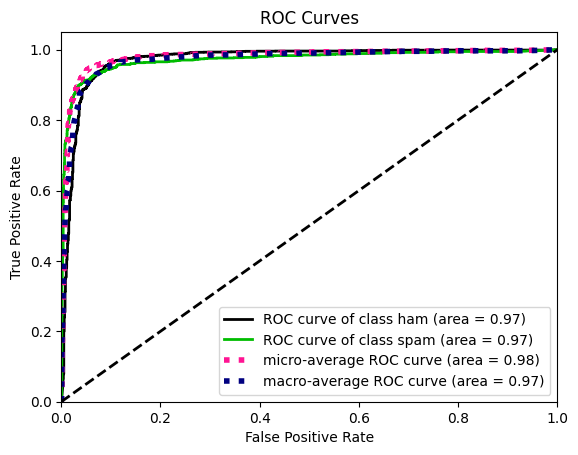

In [184]:
import scikitplot

#This function plots ROC curves for all classes and micro/macro average ROC curve

scikitplot.metrics.plot_roc(y_test, probabilities)

In [185]:
#!pip install spam-detector-ai

In [186]:
'''
import nltk

nltk.download('wordnet')
nltk.download('stopwords')
'''

"\nimport nltk\n\nnltk.download('wordnet')\nnltk.download('stopwords')\n"

In [187]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm

In [188]:
cv = CountVectorizer()
features = cv.fit_transform(X_train)

In [189]:
print(features.shape)

(12209, 45287)


In [190]:
model1 = svm.SVC(probability=True)
model1.fit(features,y_train)

SVC(probability=True)

In [191]:
features_test = cv.transform(X_test)
print(model1.score(features_test,y_test))

0.9316953316953317


In [192]:
print(features_test)

  (0, 0)	1
  (0, 2287)	1
  (0, 4711)	1
  (0, 5748)	1
  (0, 6585)	1
  (0, 9933)	1
  (0, 11073)	2
  (0, 13155)	1
  (0, 15455)	1
  (0, 17508)	1
  (0, 18939)	1
  (0, 19790)	1
  (0, 20287)	1
  (0, 22962)	1
  (0, 23534)	2
  (0, 25177)	2
  (0, 25722)	1
  (0, 25723)	1
  (0, 27116)	1
  (0, 28093)	1
  (0, 31315)	1
  (0, 32109)	1
  (0, 35850)	1
  (0, 36921)	1
  (0, 38159)	1
  :	:
  (4067, 26220)	1
  (4067, 27117)	1
  (4067, 35341)	1
  (4067, 38735)	2
  (4067, 39113)	1
  (4068, 513)	1
  (4068, 7393)	5
  (4068, 8405)	1
  (4068, 21597)	1
  (4068, 22105)	1
  (4068, 22603)	1
  (4068, 23953)	1
  (4068, 25255)	1
  (4068, 26077)	1
  (4068, 26582)	1
  (4068, 27273)	1
  (4068, 27432)	1
  (4068, 30193)	1
  (4068, 36306)	1
  (4068, 36856)	2
  (4068, 37065)	1
  (4068, 38066)	1
  (4068, 39229)	1
  (4069, 20342)	1
  (4069, 25723)	1


In [193]:
print((model1.predict_proba(features_test)))

[[6.72750422e-01 3.27098161e-01 1.51416996e-04]
 [1.42317283e-01 8.57331914e-01 3.50803200e-04]
 [9.50013666e-01 4.98557462e-02 1.30587753e-04]
 ...
 [9.98781461e-01 1.09763486e-03 1.20904025e-04]
 [1.69250586e-03 9.98083195e-01 2.24299526e-04]
 [4.41870181e-01 5.57690172e-01 4.39647279e-04]]


In [194]:
model1.predict_proba

<bound method BaseSVC.predict_proba of SVC(probability=True)>

In [205]:
temp = (model1.predict_proba(features_test))
tempp = []
posos = []
for i in temp:
  if i[0]>i[1]:
    tempp.append([i[0]+i[2], i[1]])
    posos.append(i[0])

  else:
    tempp.append([i[0], i[1]+i[2]])
    posos.append(i[1])



In [206]:
import sklearn
print(sklearn.metrics.roc_auc_score(y_test, posos))

0.5482413225142868


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

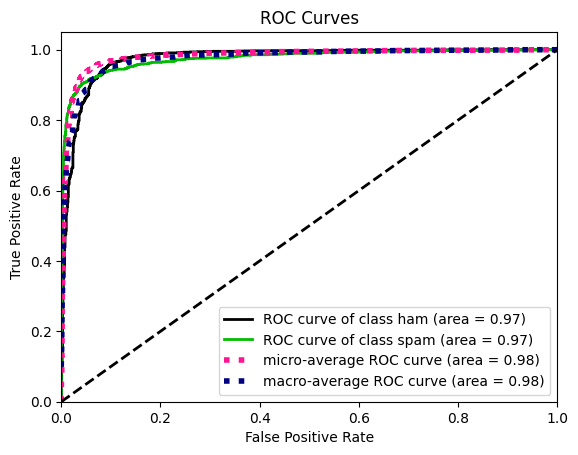

In [197]:
scikitplot.metrics.plot_roc(y_test, tempp)

In [198]:
from sklearn.linear_model import LogisticRegression

cv = CountVectorizer()
features = cv.fit_transform(X_train)

lr_basic = LogisticRegression(solver='saga', tol=1e-3, max_iter=500).fit(features, y_train)

In [199]:
features_test = cv.transform(X_test)
print(y_test.shape)
print(lr_basic.predict_proba(features_test))

(4070,)
[[9.69892826e-01 3.01035821e-02 3.59178836e-06]
 [1.52991232e-01 7.83047372e-01 6.39613962e-02]
 [8.24888160e-01 1.69630424e-01 5.48141678e-03]
 ...
 [9.57056741e-01 4.05315689e-02 2.41169009e-03]
 [2.75121323e-02 9.70601373e-01 1.88649450e-03]
 [3.05914693e-01 6.31944154e-01 6.21411529e-02]]


In [200]:
temp = (lr_basic.predict_proba(features_test))
tempp = []
posos = []
for i in temp:
  if i[0]>i[1]:
    tempp.append([i[0]+i[2], i[1]])
    posos.append(i[0])
  else:
    tempp.append([i[0], i[1]+i[2]])
    posos.append(i[1])

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

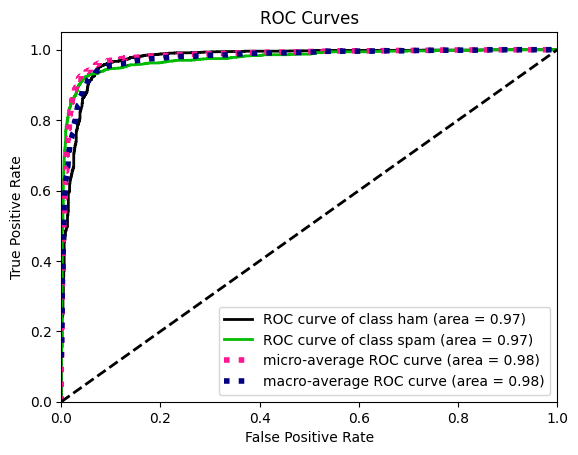

In [201]:
scikitplot.metrics.plot_roc(y_test, tempp)

In [202]:
import sklearn
print(sklearn.metrics.roc_auc_score(y_test, posos))

0.4514546538906866
